<a href="https://colab.research.google.com/github/cbsobral/python/blob/master/topic_choices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data

In [ ]:
# install and update packages
#!pip install pyLDAvis
#!pip install -U gensim

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# import packages 
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
import gensim
from gensim import corpora, models
import pandas as pd
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
from matplotlib import pyplot as plt

In [ ]:
# import supervision plans from drive
"""
This will only run with Google Drive access. To reproduce the code, the same folder can be found on the GitHub page: 
https://github.com/cbsobral/python/tree/master/data/txt_prof
"""
url = (r'/content/drive/My Drive/data/')
corpus_list = PlaintextCorpusReader(url, '.*txt')  # import all files ending in 'txt'

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

wordnet = nltk.WordNetLemmatizer()
stoplist = stopwords.words('english')

# define additional stopwords in a string
additional_stopwords = """http question impact professor school dissertation paper take following nuffield
                          title school session study work topics project partner practice happy plan see supervise
                          research thesis issue design student topic supervision university lab mia mpp org etc"""  

stoplist += additional_stopwords.split() # join both lists

In [ ]:
# convert token to lowercase and stem using the Porter algorithm
def normalize_token(token):
  return wordnet.lemmatize(token.lower())

# evaluate whether or not to retain `token`
def filter_token(token):
    token = token.lower()
    return token not in stoplist and token.isalpha() and len(token) > 1

In [ ]:
# tokenize and apply normalize and filter functions to files
documents=[[normalize_token(token) 
            for token in corpus_list.words(fileids=[fileid])
            if filter_token(token)]
            for fileid in corpus_list.fileids()]

# create bag of words for each document
dictionary = gensim.corpora.Dictionary(documents)         
documents_bow = [dictionary.doc2bow(document) for document in documents]

## LDA
Latent Dirichlet Allocation Model

### Model

In [ ]:
# run model
lda_model = gensim.models.LdaModel(documents_bow, 
                               id2word=dictionary,
                               num_topics=10, # best results with 10 topics
                               random_state=123, # seed for consistency
                               passes=500)

### LDA Visualization

In [ ]:
# visualize words per topic
for i, topic in enumerate(lda_model.print_topics(num_topics=10, num_words=7)):
    print (i, ':', topic)

0 : (0, '0.016*"empirical" + 0.014*"policy" + 0.011*"data" + 0.007*"security" + 0.007*"political" + 0.006*"question" + 0.006*"etc"')
1 : (1, '0.022*"public" + 0.018*"policy" + 0.010*"government" + 0.010*"medium" + 0.009*"analysis" + 0.009*"digital" + 0.009*"data"')
2 : (2, '0.015*"electricity" + 0.014*"market" + 0.013*"energy" + 0.010*"review" + 0.010*"system" + 0.009*"law" + 0.009*"migration"')
3 : (3, '0.018*"policy" + 0.011*"economic" + 0.011*"social" + 0.009*"law" + 0.009*"comparative" + 0.009*"political" + 0.007*"european"')
4 : (4, '0.018*"politics" + 0.012*"political" + 0.010*"case" + 0.010*"governance" + 0.008*"student" + 0.006*"qualitative" + 0.006*"colloquium"')
5 : (5, '0.014*"international" + 0.013*"analysis" + 0.011*"policy" + 0.011*"governance" + 0.008*"approach" + 0.007*"education" + 0.007*"development"')
6 : (6, '0.019*"social" + 0.012*"organizational" + 0.012*"corporate" + 0.010*"student" + 0.009*"business" + 0.009*"meeting" + 0.009*"sage"')
7 : (7, '0.012*"science" + 

In [ ]:
# create table with top 10 words per topic
n_words = 10
topic_words = pd.DataFrame({})

for i, topic in enumerate(lda_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

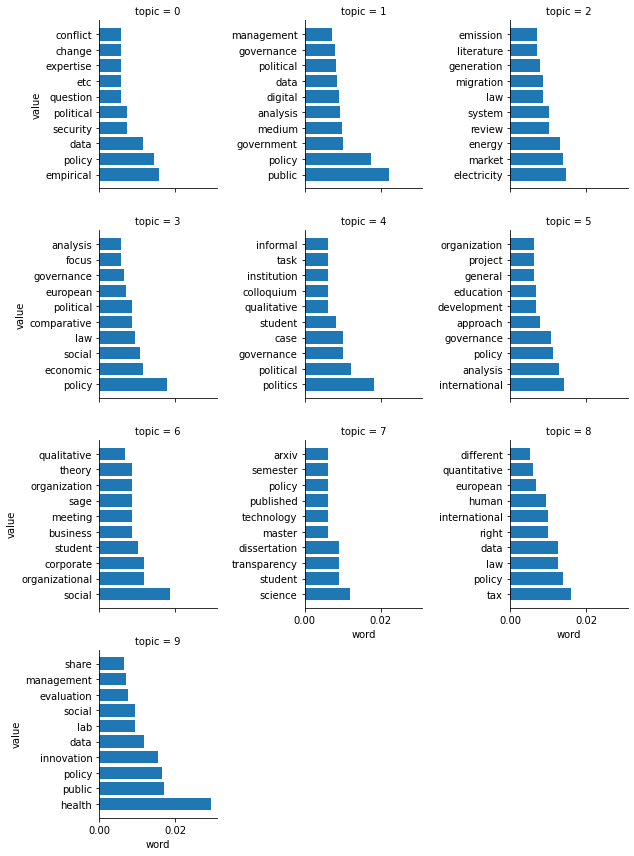

In [ ]:
# visualize table above
g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value")

In [ ]:
# visualize model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, documents_bow, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.068413 -0.013956       1        1  27.357014
5      0.047907 -0.063565       2        1  15.319307
8     -0.023356 -0.101782       3        1  12.527646
3      0.065828 -0.057319       4        1  11.624306
2     -0.207430 -0.036070       5        1  10.416128
9      0.045880 -0.046863       6        1   8.347103
0     -0.008369  0.028515       7        1   4.447236
7     -0.050022  0.111709       8        1   4.193386
6      0.041547  0.108238       9        1   3.371242
4      0.019602  0.071094      10        1   2.396633, topic_info=              Term       Freq      Total Category  logprob  loglift
1310        health  29.000000  29.000000  Default  30.0000  30.0000
150         public  83.000000  83.000000  Default  29.0000  29.0000
174         social  56.000000  56.000000  Default  28.0000  28.0000
540       politics  22.000000  22.000000  Default  27.0000  27.0000
950            tax  22.000000  22.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
36     comparative   0.988026  39.827844  Topic10  -5.4763   0.0345
486       european   0.988026  33.024514  Topic10  -5.4763   0.2218
167        science   0.988026  27.986761  Topic10  -5.4763   0.3873
152   quantitative   0.988026  32.944941  Topic10  -5.4763   0.2242
113         method   0.988025  46.403891  Topic10  -5.4763  -0.1183

[796 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
200       1  0.336171      able
200       5  0.336171      able
200       8  0.336171      able
0         1  0.250728  academic
0         2  0.501456  academic
...     ...       ...       ...
435       8  0.109127       www
1744      2  0.827842       yet
1963      9  0.785086       yin
1613      1  0.348359     youth
1613      7  0.348359     youth

[1544 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 9, 4, 3, 10, 1, 8, 7, 5])

In [ ]:
# topics per document in corpus
documents_lda = lda_model[documents_bow]

# create table with doc_id and most prevalent topics per document
doc_id_dt = pd.DataFrame(documents_lda)

# supervisor names to index column
doc_id_dt.index = ['Anheier', 'Bryson', 'Cali', 'Cingolani', 'Costello', 'Dawson', 'Flachsland', 'GohdesHW', 
                        'Graf', 'Hallerberg', 'Hammerschmid', 'Hassel', 'Hirth', 'Hustedt', 'Iacovone', 'Jachtenfuchs', 
                        'Jankin', 'Kayser', 'Kreyenfeld', 'Mair', 'Mena', 'MungiuPippidi', 'Munzert', 'Patz', 'Reh', 
                        'Roemmele', 'Shaikh', 'Snower', 'Stockman', 'Traxler', 'Wegrich']

doc_id_dt.columns = ['first_topic', 'second_topic']
doc_id_dt.sort_values(['first_topic'], ascending=True, inplace=True)
doc_id_dt

,first_topic,second_topic
Iacovone,"(0, 0.9950812)",None
GohdesHW,"(0, 0.9964836)",None
Cingolani,"(1, 0.47787565)","(9, 0.5171844)"
Hustedt,"(1, 0.99603385)",None
Flachsland,"(1, 0.99761814)",None
Hammerschmid,"(1, 0.99772084)",None
Munzert,"(1, 0.99790627)",None
Stockman,"(1, 0.9981994)",None
MungiuPippidi,"(1, 0.99870825)",None
Costello,"(2, 0.99662834)",None


In [ ]:
# topic probabilities per document
topics = [lda_model[documents_bow[i]] for i in range(len(documents))]
num_topics = 10

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

# supervisor names to index column
document_topic.index = ['Anheier', 'Bryson', 'Cali', 'Cingolani', 'Costello', 'Dawson', 'Flachsland', 'GohdesHW', 
                        'Graf', 'Hallerberg', 'Hammerschmid', 'Hassel', 'Hirth', 'Hustedt', 'Iacovone', 'Jachtenfuchs', 
                        'Jankin', 'Kayser', 'Kreyenfeld', 'Mair', 'Mena', 'MungiuPippidi', 'Munzert', 'Patz', 'Reh', 
                        'Roemmele', 'Shaikh', 'Snower', 'Stockman', 'Traxler', 'Wegrich']

document_topic # table with topic probabilities per document

,0,1,2,3,4,5,6,7,8,9
Anheier,0.000000,0.000000,0.000000,0.000000,0.00000,0.996750,0.000000,0.000000,0.000000,0.000000
Bryson,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.997815,0.000000,0.000000
Cali,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.997142,0.000000
Cingolani,0.000000,0.477864,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.517196
Costello,0.000000,0.000000,0.996628,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Dawson,0.000000,0.000000,0.000000,0.995713,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Flachsland,0.000000,0.997618,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
GohdesHW,0.996484,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Graf,0.000000,0.000000,0.000000,0.000000,0.00000,0.997692,0.000000,0.000000,0.000000,0.000000
Hallerberg,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.997029


### LDA Comparison
Applies LDA model to unseen document -- Students' Master Thesis Projects


> Here we give two choices for inserting doc for comparison: add plain text in `ud_text` or a path to a document in `ud_path`




In [ ]:
#@title Add Text { run: "auto", vertical-output: true }

ud_text = "health inequality" #@param {type:"string"}



In [ ]:
#@title Add Document
path = "/content/drive/My Drive/docs/ana.txt" #@param {type:"string"}
ud_p = open(path)
ud_path = ud_p.read()

In [ ]:
# tokenize and create bag of words for unseen document
# ud can be either `ud_text` or `ud_path`
ud_tokens = nltk.word_tokenize(ud_path) # recommendation for `ud_path`
ud_bow_vector = dictionary.doc2bow(ud_tokens)

In [ ]:
# table with proximity score for top three topics related to unseen doc
results = pd.DataFrame(lda_model[ud_bow_vector])
results.columns = ['topic', 'proximity']
results.sort_values(['proximity'], ascending=False, inplace=True)
print(results.nlargest(3,['proximity']))

In [ ]:
# presenting results to user as a list of words based on `results` table
results_dt = pd.DataFrame(results.nlargest(3,['proximity']))

# transform top three topics into variables 
first_choice = int(results_dt.iloc[0]['topic'])
second_choice = int(results_dt.iloc[1]['topic'])
third_choice = int(results_dt.iloc[2]['topic'])

# first topic top words table with `first_choice`
words1 = pd.DataFrame(topic_words[topic_words['topic'] == first_choice])
#words1 = words1[['word']].to_string(index = False, header = None)

# second topic
words2 = pd.DataFrame(topic_words[topic_words['topic'] == second_choice])
#words2 = words2[['word']].to_string(index = False, header = None)

# third topic
words3 = pd.DataFrame(topic_words[topic_words['topic'] == third_choice])
#words3 = words3[['word']].to_string(index = False, header = None)

# create table containing all three lists of words
all_words = pd.concat([words1, words2, words3], ignore_index=True)


# pivot table 
pivot_table = all_words.pivot_table(index=None,
                                     columns='topic', 
                                     values='word',
                                     aggfunc=lambda x: ', '.join(x))

print("Our algorithm indicates that Topics",first_choice,",",second_choice, "and",third_choice,"are the best match to your research proposal!\nHere is a list of the ten words most frequently associated with these topics:\n")
#print(words1.title(), words2.title(), words3.title(), sep='\n')
pivot_table


In [ ]:
#@title Which topic best relates to your research?

ud_topic_input = 9 #@param {type:"integer"}

#prompt user to choose among 3 topics based on 10 top words per topic table [`words1`, `words3` or `words3`]

In [ ]:
"""
 From ud_topic_input  -- previous step
    Find and print top 5 doc_ids (with prop > 0) based on user's choice
"""
ud_recommend = pd.DataFrame(document_topic.sort_values(ud_topic_input, ascending=False)[ud_topic_input]).head(5)  # from document_topic table
ud_recommend.columns = ['prob']
ud_recommend = ud_recommend[ud_recommend.prob > 0]
print(*ud_recommend.index.tolist(), sep='\n')

## TF-IDF


> Here we use the *Term Frequency-Inverse Document Frequency* model from gensim to asess whether it provides better recommendations. The same visualizations and comparison are displayed.






### Model

In [ ]:
"""
The same data from the *Data* section is used here. 
"""
# create bag of words for each document
documents_idf = models.TfidfModel(documents_bow) # same bow from lda_model, converted to tf-idf
corpus_tfidf = documents_idf[documents_bow] # final bow for tf-idf model -- equates `documents_bow` for lda_model

In [ ]:
# run model
tfidf_model= gensim.models.LdaMulticore(corpus_tfidf, 
                                         id2word=dictionary,
                                         num_topics=6, 
                                         random_state=123, 
                                         passes=500)

### TF-IDF Visualization

In [ ]:
# visualize words per topic
for i, topic in enumerate(tfidf_model.print_topics(num_topics=10, num_words=7)):
    print (i, ':', topic)

0 : (0, '0.001*"electricity" + 0.001*"family" + 0.001*"ercas" + 0.001*"behaviour" + 0.001*"energy" + 0.001*"market" + 0.001*"client"')
1 : (1, '0.001*"corporate" + 0.001*"sdg" + 0.001*"aid" + 0.001*"organizational" + 0.001*"power" + 0.001*"preference" + 0.001*"http"')
2 : (2, '0.002*"law" + 0.001*"public" + 0.001*"lab" + 0.001*"educational" + 0.001*"legal" + 0.001*"migration" + 0.001*"sector"')
3 : (3, '0.001*"labour" + 0.001*"ministry" + 0.001*"affair" + 0.001*"federal" + 0.001*"hightech" + 0.001*"labor" + 0.001*"submit"')
4 : (4, '0.001*"law" + 0.001*"management" + 0.001*"smart" + 0.001*"right" + 0.001*"public" + 0.001*"human" + 0.001*"politics"')
5 : (5, '0.002*"health" + 0.001*"tax" + 0.001*"international" + 0.001*"climate" + 0.001*"mair" + 0.001*"security" + 0.001*"inequality"')


In [ ]:
# create table with top 10 words per topic
n_words = 10
topic_words = pd.DataFrame({})

for i, topic in enumerate(tfidf_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

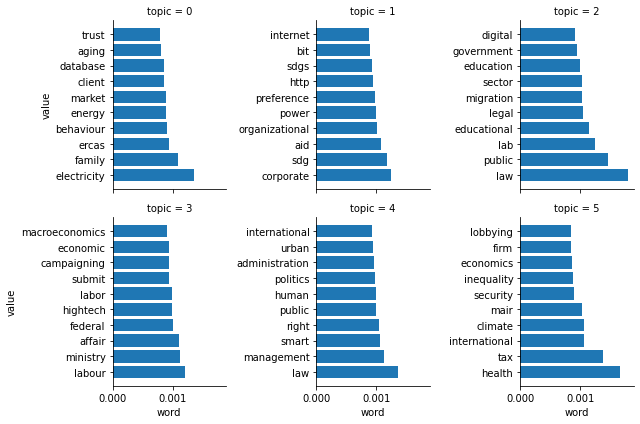

In [ ]:
# visualize table above
g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value")

In [ ]:
# visualize model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(tfidf_model, corpus_tfidf, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.007974 -0.003463       1        1  28.979235
5     -0.006688 -0.004629       2        1  26.709830
1     -0.000824  0.003240       3        1  13.008679
4      0.000830  0.001702       4        1  12.687572
0     -0.000837  0.001711       5        1  11.313786
3     -0.000454  0.001439       6        1   7.300898, topic_info=             Term      Freq     Total Category  logprob  loglift
316        labour  0.000000  0.000000  Default  30.0000  30.0000
1376  electricity  0.000000  0.000000  Default  29.0000  29.0000
518           law  0.000000  0.000000  Default  28.0000  28.0000
1312     ministry  0.000000  0.000000  Default  27.0000  27.0000
5          affair  0.000000  0.000000  Default  26.0000  26.0000
...           ...       ...       ...      ...      ...      ...
1215     addition  0.017028  0.134320   Topic6  -7.2885   0.5518
51      economics  0.018798  0.181924   Topic6  -7.1896   0.3473
1787     populism  0.017673  0.152297   Topic6  -7.2513   0.4634
1106       market  0.017920  0.165851   Topic6  -7.2374   0.3920
195       welfare  0.017082  0.146201   Topic6  -7.2853   0.4702

[305 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 2, 5, 1, 4])

In [ ]:
# topics per document in corpus
documents_tfidf = tfidf_model[corpus_tfidf]

# create table with doc_id and most prevalent topics per document
doc_id_dt = pd.DataFrame(documents_tfidf)

# supervisor names to index column
doc_id_dt.index = ['Anheier', 'Bryson', 'Cali', 'Cingolani', 'Costello', 'Dawson', 'Flachsland', 'GohdesHW', 
                        'Graf', 'Hallerberg', 'Hammerschmid', 'Hassel', 'Hirth', 'Hustedt', 'Iacovone', 'Jachtenfuchs', 
                        'Jankin', 'Kayser', 'Kreyenfeld', 'Mair', 'Mena', 'MungiuPippidi', 'Munzert', 'Patz', 'Reh', 
                        'Roemmele', 'Shaikh', 'Snower', 'Stockman', 'Traxler', 'Wegrich']

#doc_id_dt.columns = ['first_topic', 'second_topic']
#doc_id_dt.sort_values(['first_topic'], ascending=True, inplace=True)
doc_id_dt

,0,1,2,3,4,5
Anheier,"(0, 0.012404779)","(1, 0.012417843)","(2, 0.012506277)","(3, 0.012424693)","(4, 0.012419112)","(5, 0.9378273)"
Bryson,"(0, 0.011352305)","(1, 0.011358111)","(2, 0.9432047)","(3, 0.011353917)","(4, 0.0113514615)","(5, 0.011379505)"
Cali,"(0, 0.015025288)","(1, 0.015052779)","(2, 0.015154885)","(3, 0.015019354)","(4, 0.9246287)","(5, 0.015119005)"
Cingolani,"(0, 0.015541877)","(1, 0.015573757)","(2, 0.9221931)","(3, 0.015541939)","(4, 0.015583893)","(5, 0.015565412)"
Costello,"(0, 0.015445098)","(1, 0.01544643)","(2, 0.9227)","(3, 0.015436246)","(4, 0.015454264)","(5, 0.015517924)"
Dawson,"(0, 0.017889049)","(1, 0.017873844)","(2, 0.9105167)","(3, 0.017880322)","(4, 0.017920803)","(5, 0.017919237)"
Flachsland,"(0, 0.01225072)","(1, 0.012251174)","(2, 0.0123219015)","(3, 0.012244937)","(4, 0.012274037)","(5, 0.9386572)"
GohdesHW,"(0, 0.012562013)","(1, 0.012581498)","(2, 0.012639586)","(3, 0.012575695)","(4, 0.012585823)","(5, 0.9370554)"
Graf,"(0, 0.01368967)","(1, 0.013702068)","(2, 0.93147224)","(3, 0.013683363)","(4, 0.013683575)","(5, 0.013769037)"
Hallerberg,"(0, 0.014562681)","(1, 0.014561434)","(2, 0.9270967)","(3, 0.014574951)","(4, 0.014575109)","(5, 0.0146291)"


In [ ]:
# topic probabilities per document
topics = [tfidf_model[documents_bow[i]] for i in range(len(documents))]
num_topics = 6

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

# supervisor names to index column
document_topic.index = ['Anheier', 'Bryson', 'Cali', 'Cingolani', 'Costello', 'Dawson', 'Flachsland', 'GohdesHW', 
                        'Graf', 'Hallerberg', 'Hammerschmid', 'Hassel', 'Hirth', 'Hustedt', 'Iacovone', 'Jachtenfuchs', 
                        'Jankin', 'Kayser', 'Kreyenfeld', 'Mair', 'Mena', 'MungiuPippidi', 'Munzert', 'Patz', 'Reh', 
                        'Roemmele', 'Shaikh', 'Snower', 'Stockman', 'Traxler', 'Wegrich']

document_topic # table with topic probabilities per document

,0,1,2,3,4,5
Anheier,0.000000,0.000000,0.046520,0.000000,0.000000,0.951056
Bryson,0.000000,0.000000,0.997959,0.000000,0.000000,0.000000
Cali,0.000000,0.000000,0.124056,0.000000,0.845072,0.029269
Cingolani,0.000000,0.000000,0.994827,0.000000,0.000000,0.000000
Costello,0.000000,0.000000,0.996852,0.000000,0.000000,0.000000
Dawson,0.000000,0.000000,0.996004,0.000000,0.000000,0.000000
Flachsland,0.000000,0.000000,0.020499,0.000000,0.000000,0.977720
GohdesHW,0.000000,0.000000,0.000000,0.000000,0.000000,0.996717
Graf,0.000000,0.000000,0.997060,0.000000,0.000000,0.000000
Hallerberg,0.000000,0.000000,0.997226,0.000000,0.000000,0.000000


### TF-IDF Comparison
Applies TF-IDF model to unseen document -- Students' Master Thesis Projects


> Here we give two choices for inserting doc for comparison: add plain text in `ud_text` or a path to a document in `ud_path`




In [ ]:
#@title Add Text { run: "auto", vertical-output: true }

ud_text = "health inequality" #@param {type:"string"}



In [ ]:
#@title Add Document
path = "/content/drive/My Drive/docs/ana.txt" #@param {type:"string"}
ud_p = open(path)
ud_path = ud_p.read()

In [ ]:
# tokenize and create bag of words for unseen document
# ud can be either `ud_text` or `ud_path`
ud_tokens = nltk.word_tokenize(ud_path) # recommendation for `ud_path`
ud_bow_vector = dictionary.doc2bow(ud_tokens)

In [ ]:
# table with proximity score for top three topics related to unseen doc
results = pd.DataFrame(lda_model[ud_bow_vector])
results.columns = ['topic', 'proximity']
results.sort_values(['proximity'], ascending=False, inplace=True)
print(results.nlargest(3,['proximity']))

   topic  proximity
0      1   0.370518
6      8   0.229747
2      3   0.113357


In [ ]:
# presenting results to user as a list of words based on `results` table
results_dt = pd.DataFrame(results.nlargest(3,['proximity']))

# transform top three topics into variables 
first_choice = int(results_dt.iloc[0]['topic'])
second_choice = int(results_dt.iloc[1]['topic'])
third_choice = int(results_dt.iloc[2]['topic'])

# first topic top words table with `first_choice`
words1 = pd.DataFrame(topic_words[topic_words['topic'] == first_choice])
#words1 = words1[['word']].to_string(index = False, header = None)

# second topic
words2 = pd.DataFrame(topic_words[topic_words['topic'] == second_choice])
#words2 = words2[['word']].to_string(index = False, header = None)

# third topic
words3 = pd.DataFrame(topic_words[topic_words['topic'] == third_choice])
#words3 = words3[['word']].to_string(index = False, header = None)

# create table containing all three lists of words
all_words = pd.concat([words1, words2, words3], ignore_index=True)


# pivot table 
pivot_table = all_words.pivot_table(index=None,
                                     columns='topic', 
                                     values='word',
                                     aggfunc=lambda x: ', '.join(x))

print("Our algorithm indicates that Topics",first_choice,",",second_choice, "and",third_choice,"are the best match to your research proposal!\nHere is a list of the ten words most frequently associated with these topics:\n")
#print(words1.title(), words2.title(), words3.title(), sep='\n')
pivot_table


Our algorithm indicates that Topics 1 , 8 and 3 are the best match to your research proposal!
Here is a list of the ten words most frequently associated with these topics:



topic,1,3
word,"corporate, sdg, aid, organizational, power, pr...","labour, ministry, affair, federal, hightech, l..."


In [73]:
#@title Which topic best relates to your research?

ud_topic_input = 1 #@param {type:"integer"}

#prompt user to choose among 3 topics based on 10 top words per topic table [`words1`, `words3` or `words3`]

In [74]:
"""
 From ud_topic_input  -- previous step
    Find and print top 5 doc_ids (with prop > 0) based on user's choice
"""
ud_recommend = pd.DataFrame(document_topic.sort_values(ud_topic_input, ascending=False)[ud_topic_input]).head(5)  # from document_topic table
ud_recommend.columns = ['prob']
ud_recommend = ud_recommend[ud_recommend.prob > 0]
print(*ud_recommend.index.tolist(), sep='\n')

Mena
Jachtenfuchs
Jankin
Munzert
